In [1]:
import numpy as np
import pandas as pd

### Import dataset

In [2]:
df_raw = pd.read_csv('./data/tumor.csv')
df_raw.head(5)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Pre-processing

In [3]:
print(df_raw.shape)
print(df_raw.isnull().sum())
df = df_raw

(683, 11)
Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64


##### Basic stats for numerical columns

In [4]:
all_columns = df.columns
print(f'All columns: {all_columns}')

unwanted_columns = ['Sample code number', 'Class']
feature_columns = [col for col in all_columns if col not in unwanted_columns]
print(f'Feature Columns: {feature_columns}')

df.loc[:, feature_columns].describe()

All columns: Index(['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')
Feature Columns: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


##### Correlation

In [5]:
df_corr = df.loc[:, feature_columns].corr()
df_corr.style.applymap(lambda x: 'background-color: yellow' if x > 0.7 else '')


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
Clump Thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957
Uniformity of Cell Size,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755
Uniformity of Cell Shape,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258
Marginal Adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898
Single Epithelial Cell Size,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583
Bare Nuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210
Bland Chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011
Normal Nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757
Mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000


##### Formatting

In [6]:
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, downcast='float')

In [7]:
df.replace({'Class': {2: 0, 4: 1}}, inplace=True)

### Split into train-validate-test

In [8]:
n = df.shape[0] // 10

column_list = list(all_columns)
column_list.remove('Sample code number')
df_population = df.loc[:, column_list].copy()

df_test = df_population.sample(n=n)
df_population.drop(df_test.index, inplace=True)
df_validate = df_population.sample(n=n)
df_train = df_population.drop(df_validate.index)

df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)

print(f'Train size: {df_train.shape}')
print(f'Test size: {df_test.shape}')
print(f'Validate size: {df_validate.shape}')

Train size: (547, 10)
Test size: (68, 10)
Validate size: (68, 10)


### Setup and Compare

In [9]:
from pycaret.classification import *
exp_clf = setup(data=df_train, target='Class', test_data=df_validate, normalize=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,Class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(547, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [10]:
top3 = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9709,0.9920,0.9734,0.9472,0.9590,0.9365,0.9380,0.0920
rf,Random Forest Classifier,0.9654,0.9883,0.9520,0.9517,0.9500,0.9236,0.9257,0.1100
gbc,Gradient Boosting Classifier,0.9618,0.9920,0.9418,0.9516,0.9435,0.9147,0.9181,0.0310
nb,Naive Bayes,0.9617,0.9826,0.9678,0.9268,0.9457,0.9162,0.9181,0.0090
lr,Logistic Regression,0.9599,0.9939,0.9360,0.9510,0.9413,0.9109,0.9133,0.4580
knn,K Neighbors Classifier,0.9599,0.9856,0.9412,0.9458,0.9415,0.9110,0.9133,0.0160
svm,SVM - Linear Kernel,0.9563,0.0000,0.9468,0.9311,0.9372,0.9037,0.9057,0.0080
ridge,Ridge Classifier,0.9544,0.0000,0.9044,0.9637,0.9291,0.8959,0.9006,0.0100
lda,Linear Discriminant Analysis,0.9544,0.9933,0.9044,0.9637,0.9291,0.8959,0.9006,0.0080
lightgbm,Light Gradient Boosting Machine,0.9526,0.9924,0.9307,0.9349,0.9311,0.8950,0.8969,0.0210


In [11]:
results = pull()
results.Model.to_list()[:5]

['Extra Trees Classifier',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'Naive Bayes',
 'Logistic Regression']

### Setup with additional parameters and Compare

In [12]:
exp_clf2 = setup(data=df_train, target='Class', test_data=df_test, normalize=True, transformation=True, remove_multicollinearity=True, multicollinearity_threshold=0.9, session_id=123)

,Description,Value
0,session_id,123
1,Target,Class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(547, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9708,0.9873,0.9787,0.9416,0.9587,0.9362,0.9378,0.0150
lr,Logistic Regression,0.9690,0.9911,0.9629,0.9522,0.9559,0.9321,0.9340,0.0130
ridge,Ridge Classifier,0.9672,0.0000,0.9681,0.9416,0.9533,0.9281,0.9299,0.0080
lda,Linear Discriminant Analysis,0.9672,0.9901,0.9681,0.9416,0.9533,0.9281,0.9299,0.0110
et,Extra Trees Classifier,0.9672,0.9917,0.9681,0.9419,0.9535,0.9282,0.9300,0.0920
rf,Random Forest Classifier,0.9654,0.9913,0.9626,0.9432,0.9510,0.9242,0.9265,0.1070
nb,Naive Bayes,0.9635,0.9899,0.9947,0.9104,0.9501,0.9215,0.9245,0.0080
qda,Quadratic Discriminant Analysis,0.9599,0.9907,0.9947,0.9021,0.9454,0.9139,0.9175,0.0070
gbc,Gradient Boosting Classifier,0.9581,0.9925,0.9418,0.9429,0.9395,0.9076,0.9108,0.0300
lightgbm,Light Gradient Boosting Machine,0.9581,0.9930,0.9363,0.9475,0.9396,0.9076,0.9102,0.0160


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
results = pull()
results.Model.to_list()[:5]

['K Neighbors Classifier',
 'Logistic Regression',
 'Ridge Classifier',
 'Linear Discriminant Analysis',
 'Extra Trees Classifier']

### Create a KNN and Extra Trees Model

In [15]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9636,0.9898,1.0000,0.9048,0.9500,0.9215,0.9244
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9455,0.9539,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9781,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9455,0.9671,0.8947,0.9444,0.9189,0.8779,0.8786
5,0.9636,0.9920,0.9474,0.9474,0.9474,0.9196,0.9196
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9630,0.9969,0.9444,0.9444,0.9444,0.9167,0.9167
8,0.9815,0.9954,1.0000,0.9474,0.9730,0.9589,0.9597


Create an Extra Trees model

In [16]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9455,0.9730,0.9474,0.9000,0.9231,0.8809,0.8816
1,0.9636,0.9985,0.8947,1.0000,0.9444,0.9175,0.9207
2,0.9455,0.9722,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9912,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9636,0.9890,0.9474,0.9474,0.9474,0.9196,0.9196
5,0.9636,0.9927,0.9474,0.9474,0.9474,0.9196,0.9196
6,0.9818,1.0000,1.0000,0.9500,0.9744,0.9603,0.9610
7,0.9815,1.0000,0.9444,1.0000,0.9714,0.9577,0.9586
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


### Select Extra Trees for tuning

In [17]:
tuned_model_et = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9636,0.9825,1.0000,0.9048,0.9500,0.9215,0.9244
1,0.9636,0.9971,1.0000,0.9048,0.9500,0.9215,0.9244
2,0.9455,0.9649,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9956,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9636,0.9883,0.9474,0.9474,0.9474,0.9196,0.9196
5,0.9818,0.9825,1.0000,0.9500,0.9744,0.9603,0.9610
6,0.9818,1.0000,1.0000,0.9500,0.9744,0.9603,0.9610
7,0.9815,0.9985,1.0000,0.9474,0.9730,0.9589,0.9597
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


### Ensemble the Extra Trees model

In [18]:
bagged_et = ensemble_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9636,0.9854,1.0000,0.9048,0.9500,0.9215,0.9244
1,0.9818,1.0000,0.9474,1.0000,0.9730,0.9593,0.9601
2,0.9455,0.9693,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9942,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9636,0.9898,0.9474,0.9474,0.9474,0.9196,0.9196
5,0.9636,0.9898,0.9474,0.9474,0.9474,0.9196,0.9196
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9630,0.9969,0.9444,0.9444,0.9444,0.9167,0.9167
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


In [19]:
boosted_et = ensemble_model(et, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9455,0.9846,0.9474,0.9000,0.9231,0.8809,0.8816
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9455,0.9686,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9920,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9636,0.9876,0.9474,0.9474,0.9474,0.9196,0.9196
5,0.9636,0.9898,0.9474,0.9474,0.9474,0.9196,0.9196
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9630,0.9985,0.9444,0.9444,0.9444,0.9167,0.9167
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


### Blend the ET and KNN models

In [20]:
soft_blend = blend_models(estimator_list=[et, knn], method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9636,0.9825,1.0000,0.9048,0.9500,0.9215,0.9244
1,0.9818,1.0000,0.9474,1.0000,0.9730,0.9593,0.9601
2,0.9455,0.9708,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9883,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9455,0.9890,0.8947,0.9444,0.9189,0.8779,0.8786
5,0.9636,0.9927,0.9474,0.9474,0.9474,0.9196,0.9196
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9630,0.9985,0.9444,0.9444,0.9444,0.9167,0.9167
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


In [21]:
hard_blend = blend_models(estimator_list=[et, knn], method='hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9455,0.0000,0.9474,0.9000,0.9231,0.8809,0.8816
1,0.9636,0.0000,0.8947,1.0000,0.9444,0.9175,0.9207
2,0.9455,0.0000,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.0000,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9455,0.0000,0.8947,0.9444,0.9189,0.8779,0.8786
5,0.9455,0.0000,0.8947,0.9444,0.9189,0.8779,0.8786
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9815,0.0000,0.9444,1.0000,0.9714,0.9577,0.9586
8,0.9815,0.0000,1.0000,0.9474,0.9730,0.9589,0.9597


### Plot ensembled ET model for Calibration

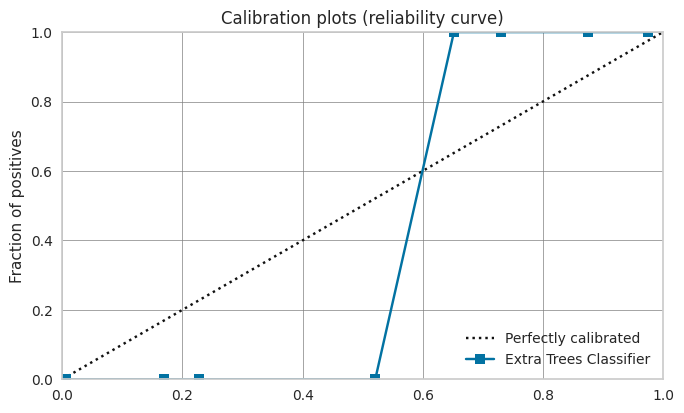

In [22]:
plot_model(bagged_et, plot='calibration')

### Calibrate model and make calibration plot

In [23]:
calibrated_et = calibrate_model(bagged_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9455,0.9825,0.9474,0.9000,0.9231,0.8809,0.8816
1,0.9818,1.0000,0.9474,1.0000,0.9730,0.9593,0.9601
2,0.9455,0.9693,1.0000,0.8636,0.9268,0.8837,0.8898
3,0.9455,0.9942,1.0000,0.8636,0.9268,0.8837,0.8898
4,0.9636,0.9883,0.9474,0.9474,0.9474,0.9196,0.9196
5,0.9636,0.9898,0.9474,0.9474,0.9474,0.9196,0.9196
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9630,1.0000,0.8889,1.0000,0.9412,0.9143,0.9177
8,0.9815,1.0000,1.0000,0.9474,0.9730,0.9589,0.9597


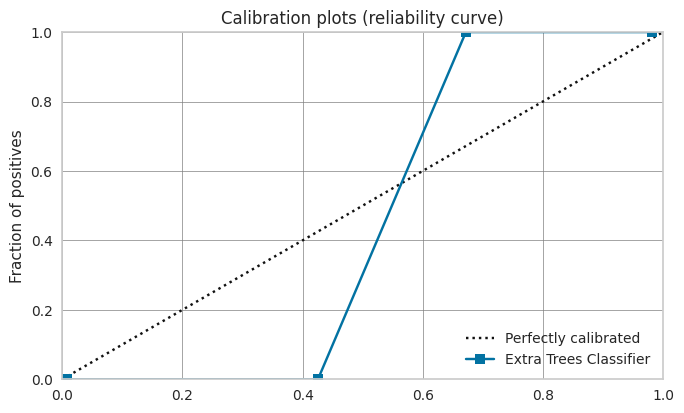

In [24]:
plot_model(calibrated_et, plot='calibration')

### Predict on test set

In [25]:
bagged_et_pred = predict_model(bagged_et, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9853,1.0000,1.0000,0.9643,0.9818,0.9695,0.9699


In [26]:
calibrated_et_predict = predict_model(soft_blend, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9853,1.0000,1.0000,0.9643,0.9818,0.9695,0.9699


In [27]:
calibrated_et_predict.loc[:, ['Class','Label','Score']].head()

,Class,Label,Score
603,0,0,1.000
497,0,0,1.000
680,1,1,0.985
595,1,1,0.995
224,1,1,0.920


In [28]:
calibrated_et_predict[calibrated_et_predict['Score'] > 0.5].shape

(68, 12)